<a href="https://colab.research.google.com/github/DhruPithadia/DhruPithadia-DataScience-GenAI-repo/blob/main/Assignment_4/5_02_Modelling_Hackathon_COMPLETE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=1xqQczl0FG-qtNA2_WQYuWePW9oU8irqJ)

# 5.02 Modelling Hackathon
We'll get a chance in this seminar to practice for the in-class test, and also to put what we have learned into practice.

To speed things up, I have done the data/feature engineering for you, you will just need to build it into a data science model. As before, you can use the code from [GitHub](https://github.com/MJMortensonWarwick/IB2AD0_Data_Science_GenerativeAI), from the internet, and/or use the Gemini AI tools.

This is an artificial dataset, and we will be predicting if students achieve a passing grade, which we will call anything above a "D".

We'll start by importing the data:

In [23]:
from google.colab import files
upload = files.upload()

Saving students_two.csv to students_two (1).csv


Now we will get the data into Pandas and inspect it:

In [24]:
import pandas as pd
df = pd.read_csv("students_two.csv")

df.head()

,Id,Student_Age,High_School_Type,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade
0,5001,21,Other,50%,Yes,No,Private,0,Always,Yes,Yes,No,No,AA
1,5002,20,Other,50%,Yes,No,Private,0,Always,Yes,No,Yes,Yes,AA
2,5003,21,State,50%,No,No,Private,2,Never,No,No,No,Yes,AA
3,5004,18,Private,50%,Yes,No,Bus,2,Always,No,Yes,No,No,AA
4,5005,22,Private,50%,No,No,Bus,12,Always,Yes,No,Yes,Yes,AA


Let's check for missing values:

In [25]:
df.isnull().sum()

,0
Id,0
Student_Age,0
High_School_Type,0
Scholarship,1
Additional_Work,0
Sports_activity,0
Transportation,0
Weekly_Study_Hours,0
Attendance,0
Reading,0


Only one missing value. Let's just drop it out of laziness:

In [26]:
df.dropna(inplace=True)
df.isnull().sum()

,0
Id,0
Student_Age,0
High_School_Type,0
Scholarship,0
Additional_Work,0
Sports_activity,0
Transportation,0
Weekly_Study_Hours,0
Attendance,0
Reading,0


We have an ID column we know won't be predictive ... so let's drop it:

In [27]:
df = df.drop(["Id"], axis=1)
df.head()

,Student_Age,High_School_Type,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade
0,21,Other,50%,Yes,No,Private,0,Always,Yes,Yes,No,No,AA
1,20,Other,50%,Yes,No,Private,0,Always,Yes,No,Yes,Yes,AA
2,21,State,50%,No,No,Private,2,Never,No,No,No,Yes,AA
3,18,Private,50%,Yes,No,Bus,2,Always,No,Yes,No,No,AA
4,22,Private,50%,No,No,Bus,12,Always,Yes,No,Yes,Yes,AA


Next we will convert some of the text features to numbers:

In [28]:
# High school
print(df['High_School_Type'].unique())

['Other' 'State' 'Private']


We can't easily convert these to a number range. Instead we should use one-hot encoding:

In [29]:
df = pd.get_dummies(df, columns=['High_School_Type'], drop_first=True, dtype=int)
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,50%,Yes,No,Private,0,Always,Yes,Yes,No,No,AA,0,0
1,20,50%,Yes,No,Private,0,Always,Yes,No,Yes,Yes,AA,0,0
2,21,50%,No,No,Private,2,Never,No,No,No,Yes,AA,0,1
3,18,50%,Yes,No,Bus,2,Always,No,Yes,No,No,AA,1,0
4,22,50%,No,No,Bus,12,Always,Yes,No,Yes,Yes,AA,1,0


We have converted this to two columns (on the far right) - "High_School_Type_Private" and "High_School_Type_State". We do not need the "Other" type as if the student is "Other" then both "Private" and "State" will be 0 (a unique combination). This is controlled by the command _drop\_first=True_. We also specify the data type (_dtype_) as __int__ so we return 0s and 1s rather than True and False.

Next we can look at Scholarship. It needs to be converted from a text representation of a percentage to a number:

In [30]:
df['Scholarship'] = df['Scholarship'].str.replace('%', '').astype(float) / 100
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,Yes,No,Private,0,Always,Yes,Yes,No,No,AA,0,0
1,20,0.5,Yes,No,Private,0,Always,Yes,No,Yes,Yes,AA,0,0
2,21,0.5,No,No,Private,2,Never,No,No,No,Yes,AA,0,1
3,18,0.5,Yes,No,Bus,2,Always,No,Yes,No,No,AA,1,0
4,22,0.5,No,No,Bus,12,Always,Yes,No,Yes,Yes,AA,1,0


"Additional_Work" is next:

In [31]:
# Additional work
print(df['Additional_Work'].unique())

['Yes' 'No']


Two values, so we can convert to 0 and 1:

In [32]:
df['Additional_Work'] = df['Additional_Work'].map({'Yes': 1, 'No': 0})
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,No,Private,0,Always,Yes,Yes,No,No,AA,0,0
1,20,0.5,1,No,Private,0,Always,Yes,No,Yes,Yes,AA,0,0
2,21,0.5,0,No,Private,2,Never,No,No,No,Yes,AA,0,1
3,18,0.5,1,No,Bus,2,Always,No,Yes,No,No,AA,1,0
4,22,0.5,0,No,Bus,12,Always,Yes,No,Yes,Yes,AA,1,0


Let's speed up now:

In [33]:
categorical_cols = ['Sports_activity', 'Transportation', 'Attendance', 'Reading', 'Notes', 'Listening_in_Class', 'Project_work', 'Grade']

for col in categorical_cols:
    print(f"Unique values for '{col}': {df[col].unique()}")

Unique values for 'Sports_activity': ['No' 'Yes']
Unique values for 'Transportation': ['Private' 'Bus']
Unique values for 'Attendance': ['Always' 'Never' 'Sometimes' '3']
Unique values for 'Reading': ['Yes' 'No']
Unique values for 'Notes': ['Yes' 'No' '6']
Unique values for 'Listening_in_Class': ['No' 'Yes' '6']
Unique values for 'Project_work': ['No' 'Yes']
Unique values for 'Grade': ['AA' 'BA' 'CC' 'Fail' 'BB' 'CB' 'DD' 'DC']


The values of '6' in 'Notes' and 'Listening_in_Class' make no sense, and neither do '3' for 'Attendance'. We'll be lazy and drop these rows (really we should check with an SME):

In [34]:
df = df[(df['Notes'] != '6') & (df['Listening_in_Class'] != '6') & (df['Attendance'] != '3')]
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,No,Private,0,Always,Yes,Yes,No,No,AA,0,0
1,20,0.5,1,No,Private,0,Always,Yes,No,Yes,Yes,AA,0,0
2,21,0.5,0,No,Private,2,Never,No,No,No,Yes,AA,0,1
3,18,0.5,1,No,Bus,2,Always,No,Yes,No,No,AA,1,0
4,22,0.5,0,No,Bus,12,Always,Yes,No,Yes,Yes,AA,1,0


Now we can convert all those "Yes" / "No" columns to 0 and 1.

In [35]:
binary_cols = ['Sports_activity', 'Reading', 'Notes', 'Listening_in_Class', 'Project_work']

for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,0,Private,0,Always,1,1,0,0,AA,0,0
1,20,0.5,1,0,Private,0,Always,1,0,1,1,AA,0,0
2,21,0.5,0,0,Private,2,Never,0,0,0,1,AA,0,1
3,18,0.5,1,0,Bus,2,Always,0,1,0,0,AA,1,0
4,22,0.5,0,0,Bus,12,Always,1,0,1,1,AA,1,0


We can also do this with "Transportation":

In [36]:
df['Transportation'] = df['Transportation'].map({'Private': 1, 'Bus': 0})
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,0,1,0,Always,1,1,0,0,AA,0,0
1,20,0.5,1,0,1,0,Always,1,0,1,1,AA,0,0
2,21,0.5,0,0,1,2,Never,0,0,0,1,AA,0,1
3,18,0.5,1,0,0,2,Always,0,1,0,0,AA,1,0
4,22,0.5,0,0,0,12,Always,1,0,1,1,AA,1,0


For Attendance an ordinal range makes sense:

In [37]:
df['Attendance'] = df['Attendance'].map({'Never': 0, 'Sometimes': 1, 'Always': 2})
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,0,1,0,2,1,1,0,0,AA,0,0
1,20,0.5,1,0,1,0,2,1,0,1,1,AA,0,0
2,21,0.5,0,0,1,2,0,0,0,0,1,AA,0,1
3,18,0.5,1,0,0,2,2,0,1,0,0,AA,1,0
4,22,0.5,0,0,0,12,2,1,0,1,1,AA,1,0


This just leaves the target - 'Grade'. To make the problem binary we'll convert 'Fail' and any grade that includes a 'D' as 0 (for fail) and the rest as 1 (pass):

In [38]:
df['Grade'] = df['Grade'].apply(lambda x: 0 if x == 'Fail' or 'D' in x else 1)
df.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,Grade,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,0,1,0,2,1,1,0,0,1,0,0
1,20,0.5,1,0,1,0,2,1,0,1,1,1,0,0
2,21,0.5,0,0,1,2,0,0,0,0,1,1,0,1
3,18,0.5,1,0,0,2,2,0,1,0,0,1,1,0
4,22,0.5,0,0,0,12,2,1,0,1,1,1,1,0


The code has a new function `lambda`. A lambda function in Python is a small, anonymous function. It's defined using the `lambda` keyword and can take any number of arguments, but can only have one expression. The expression is evaluated and returned. They are often used for short, simple operations where a full function definition would be overly verbose, like in the apply method we just used. Although the function is new, the actual mechanics are quite simple. If the data is "Fail" or contains "D" return 0, and else return 1.

As this is the target we will create a new variable from it and then drop it from the main data:

In [39]:
Y_values = df[['Grade']].values.ravel() # change to list

Y_values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1])

In [40]:
X_values = df.drop(['Grade'], axis=1)
X_values.head()

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,High_School_Type_Private,High_School_Type_State
0,21,0.5,1,0,1,0,2,1,1,0,0,0,0
1,20,0.5,1,0,1,0,2,1,0,1,1,0,0
2,21,0.5,0,0,1,2,0,0,0,0,1,0,1
3,18,0.5,1,0,0,2,2,0,1,0,0,1,0
4,22,0.5,0,0,0,12,2,1,0,1,1,1,0


We can now scale X:

In [41]:
from sklearn.preprocessing import MinMaxScaler

# create a MinMaxScaler object
scaler = MinMaxScaler()

# fit and transform the data and convert back to DataFrame
X_values = pd.DataFrame(scaler.fit_transform(X_values), columns=X_values.columns)
X_values

,Student_Age,Scholarship,Additional_Work,Sports_activity,Transportation,Weekly_Study_Hours,Attendance,Reading,Notes,Listening_in_Class,Project_work,High_School_Type_Private,High_School_Type_State
0,0.375,0.333333,1.0,0.0,1.0,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.250,0.333333,1.0,0.0,1.0,0.000000,1.0,1.0,0.0,1.0,1.0,0.0,0.0
2,0.375,0.333333,0.0,0.0,1.0,0.166667,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.000,0.333333,1.0,0.0,0.0,0.166667,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.500,0.333333,0.0,0.0,0.0,1.000000,1.0,1.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,0.500,0.333333,1.0,1.0,1.0,0.000000,1.0,0.0,1.0,0.0,1.0,0.0,1.0
136,0.000,0.666667,0.0,0.0,1.0,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,1.0
137,0.000,0.666667,0.0,0.0,1.0,0.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0
138,0.500,0.666667,1.0,1.0,0.0,1.000000,0.5,0.0,1.0,0.0,1.0,0.0,1.0


And now we can split into training and test:

In [42]:
# split data into training and test
from sklearn.model_selection  import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_values, Y_values, test_size = 0.2, random_state=1984, stratify=Y_values)

# print the shapes to check everything is OK
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(112, 13)
(28, 13)
(112,)
(28,)


And now its time for modelling ...



Your turn :)

### 1. Choosing and Training a Model
Let's start with a Logistic Regression model, a common choice for binary classification.

In [43]:
from sklearn.linear_model import LogisticRegression

# Initialise the Logistic Regression model
model = LogisticRegression(random_state=1984)

# Train the model using the training data
model.fit(X_train, Y_train)

print("Model training complete.")

Model training complete.


### 2. Making Predictions
Now, let's use the trained model to make predictions on the test set.

In [44]:
Y_pred = model.predict(X_test)

print("Predictions on test set generated.")

Predictions on test set generated.


### 3. Obtaining Evaluation metrics for the Model
We'll evaluate the model's performance using metrics like accuracy, precision, recall, and F1-score, and also display a confusion matrix.

Accuracy: 0.7143
Precision: 0.7600
Recall: 0.9048
F1-Score: 0.8261

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.14      0.20         7
           1       0.76      0.90      0.83        21

    accuracy                           0.71        28
   macro avg       0.55      0.52      0.51        28
weighted avg       0.65      0.71      0.67        28



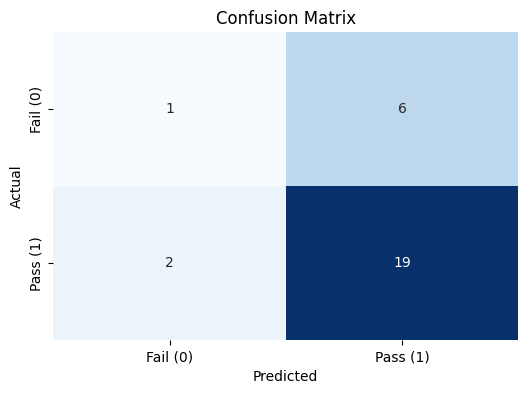

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate evaluation metrics
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(Y_test, Y_pred))

# Display Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Fail (0)', 'Pass (1)'], yticklabels=['Fail (0)', 'Pass (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 4. Evaluation of the model
Based on the evaluation metrics for the Logistic Regression model:

*   **Accuracy:** The model achieved an accuracy of approximately **0.7143**, indicating that about 71.43% of the predictions were correct.
*   **Precision:** The precision of approximately **0.7600** suggests that when the model predicts a 'Pass' (1), it is correct 76% of the time. This means 24% of the predictions for 'Pass' were actually 'Fail' (False Positives).
*   **Recall:** With a recall of approximately **0.9048**, the model successfully identified 90.48% of all actual 'Pass' (1) instances. This means only about 9.52% of actual 'Pass' students were incorrectly predicted as 'Fail' (False Negatives).
*   **F1-Score:** The F1-Score of approximately **0.8261** is the harmonic mean of precision and recall, providing a balanced measure of the model's performance, which is reasonably good for this dataset.

**Confusion Matrix Analysis:**

The confusion matrix visually represents the model's performance:
*   **True Positives (TP):** **19** - The model correctly predicted 19 students as 'Pass' (1) who actually passed.
*   **True Negatives (TN):** **1** - The model correctly predicted 1 student as 'Fail' (0) who actually failed.
*   **False Positives (FP):** **6** - The model incorrectly predicted 6 students as 'Pass' (1) who actually failed. These are Type I errors, where the model gave a false positive.
*   **False Negatives (FN):** **2** - The model incorrectly predicted 2 students as 'Fail' (0) who actually passed. These are Type II errors, where the model missed actual positive cases.

**Further Analysis:**
The model shows a high recall for the 'Pass' class, meaning it's good at identifying students who will pass. However, its precision for the 'Pass' class is lower, indicating that it also incorrectly identifies a fair number of 'Fail' students as 'Pass'. The model struggles more with identifying 'Fail' students (low True Negatives and high False Positives for the 'Fail' class, which becomes False Positives for the 'Pass' class). Depending on the cost of misclassification (e.g., the cost of incorrectly identifying a failing student as passing versus passing student as failing), further tuning might be needed to balance precision and recall.